In [15]:
import pandas as pd
import numpy as np
from copy import deepcopy

import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns
import scienceplots
plt.style.use(['science', 'no-latex'])

import os
import sys
sys.path.append(os.path.abspath('.'))
from src.plots import set_size

labelmap = {
    "cnn": "1D-CNN + MLP",
    "mlp_onehot": "MLP (One-Hot)",
    "xgb_onehot": "XGBoost (One-Hot)",
    # "mean_transformer": "Transformer (Mean Pooling)",
}

metrics = ["f1", "acc", "tpr", "misclassified_malicious", "misclassified_benign"]

LOGS_DIR = "logs_adversarial_poisoning_pollution"
LIM = None
SUBDIRS_SAME_LIM = [os.path.join(LOGS_DIR, x) for x in os.listdir(LOGS_DIR) if str(LIM) in x]

In [64]:
def read_scores_from_dir(directory, pattern):
    
    wordpuncts = [x for x in os.listdir(directory) if "wordpunct" in x]
    samples_to_ratio = {int(x.split("_")[5]): float(x.split("_")[-1].replace(".json", "")) for x in wordpuncts}
    ratio_to_samples = {v: k for k, v in samples_to_ratio.items()}

    score_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith("poisoned_scores_")]
    scores_dict = {}
    for score_file in score_files:
        if pattern not in score_file:
            continue
        poison_samples = float(score_file.split("_")[-1].replace(".json", ""))
        poison_ratio = samples_to_ratio[poison_samples]

        with open(score_file) as f:
            scores = json.load(f)
        # loop over values in scores and if nan then replace with 0
        for metric, value in scores.items():
            if np.isnan(value):
                scores[metric] = 0
        scores_dict[poison_ratio] = scores
    
    return scores_dict


def parse_scores(directories, pattern, metric="f1"):
    score_list = [read_scores_from_dir(x, pattern) for x in directories]
    metric_values = {} # key: poison ratio, value: list of metric values
    for scores in score_list:
        for poison_ratio, score in scores.items():
            if poison_ratio not in metric_values:
                metric_values[poison_ratio] = []
            metric_values[poison_ratio].append(score[metric])

    df = pd.DataFrame()
    for poison_ratio, values in metric_values.items():
        df.loc[poison_ratio, "mean"] = np.mean(values)
        df.loc[poison_ratio, "std"] = np.std(values)

    df = df.sort_index()
    df.index.name = "Poison Ratio"
    return df


def plot_scatter_lines(df, metric="f1", model_name="", xlim=None, ax=None, color="tab:blue"):
    zero_substitute = 0.0003 # for log scale when poison ratio is 0 
    scores = deepcopy(df)
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=set_size())
    
    # remove 0.0 poison ratio
    # baseline = scores.loc[0.0, "mean"]
    # scores = scores.drop(0.0)
    
    x = scores.index
    # replace 0 with 0.0001 to avoid log(0) error

    # mean as scatter plot with larger size, and std as errbars
    x = [zero_substitute if i == 0 else i for i in x]
    ax.scatter(x, scores["mean"], marker="P", label=model_name, color=color, s=100)
    ax.errorbar(x, scores["mean"], yerr=scores["std"], ls="none", capsize=3, color=color, label=model_name, linewidth=2)
    ax.plot(x, scores["mean"], ls="--", color=color, label=model_name, linewidth=2)

    # plot red dashed line for baseline
    # if plot_baseline:
    #     ax.axhline(baseline, color="red", ls="--", label=model_name, linewidth=2)

    ax.set_xlabel("Poison Ratio", fontsize=14)
    ax.set_ylabel(metric.replace("_", " ").capitalize(), fontsize=14)
    # ax.set_title(model_name)
    ax.set_xscale("log")
    vals = ax.get_xticks()
    # add 0.0003 to vals to show 0% on the plot
    vals = np.append(vals, zero_substitute)
    ax.xaxis.set_major_locator(mticker.FixedLocator(vals))
    xl = []
    for x in vals:
        if x == zero_substitute:
            xl.append("0%")
        elif x == 0.001:
            xl.append("{:.3%}".format(x/100))
        else:
            xl.append("{:.2%}".format(x/100))
    
    # place a 0% label at xlim[0]
    xl[0] = "0%"
    ax.set_xticklabels(xl, fontsize=14)
    
    # increase yticks fontsize, avoid UserWarning: FixedFormatter
    ax.tick_params(axis='y', labelsize=14)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    return ax


def joint_metric_plot(metric, max_poison_ratio=1.0):
    # create colors the size of the number of patterns
    colors = sns.color_palette("tab10", len(labelmap))

    legend_handles = []
    fig, ax = plt.subplots(1, 1, figsize=set_size())
    for i, pattern in enumerate(labelmap.keys()):
        # TODO: 1.000 to avoid 3% poison ratio
        df = parse_scores(SUBDIRS_SAME_LIM, pattern, metric=metric)[:max_poison_ratio]
        plot_scatter_lines(df, model_name="", metric=metric, ax=ax, color=colors[i], xlim=None)
        label = labelmap[pattern].replace(" + ", "\n+ ").replace(" (", "\n(")
        legend_handles.append(Line2D([0], [0], linestyle="--", marker="P", markersize=10, color=colors[i], lw=2, label=label))

    # narrow the gap between legend handles
    ax.legend(handles=legend_handles, fontsize=14, ncol=3, loc="lower center", frameon=False, borderpad=0.1, columnspacing=1.5)
    return ax

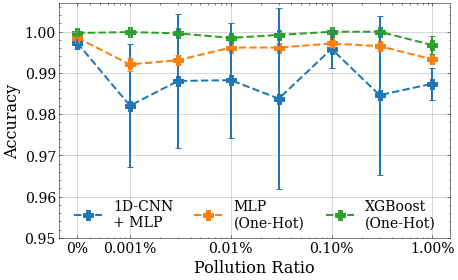

In [65]:
ax = joint_metric_plot("acc")
ax.set_ylabel("Accuracy", fontsize=16)
ax.grid(linewidth=0.5)
ax.set_title("", fontsize=16)
ax.set_ylim(0.95, 1.007)

# set x title as "Pollution Ratio"
ax.set_xlabel("Pollution Ratio", fontsize=16)
# save as pdf 
plt.savefig("img/adversarial_poisoning_pollution_acc.pdf", bbox_inches='tight', dpi=300)

### Visualizing all metrics

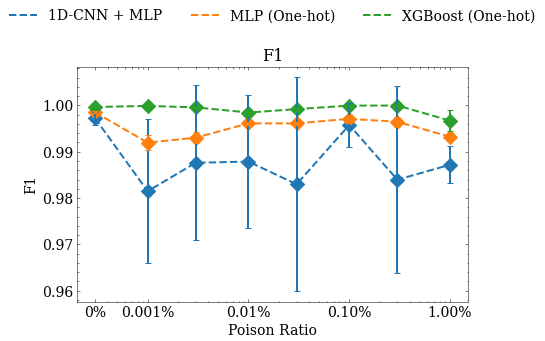

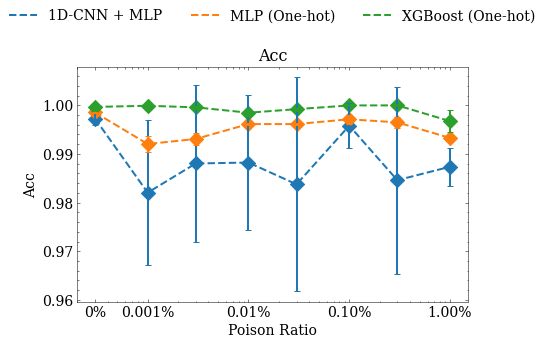

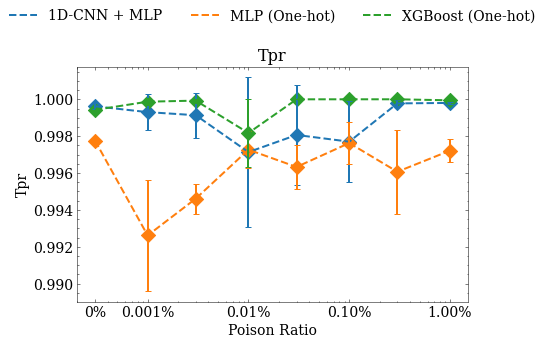

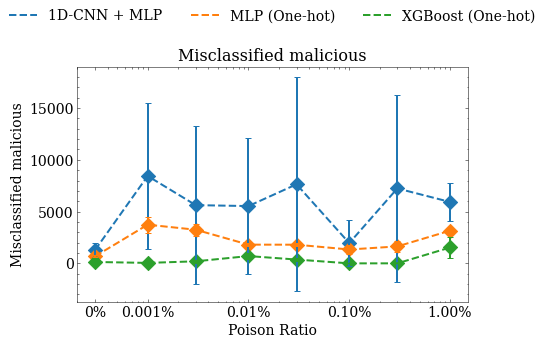

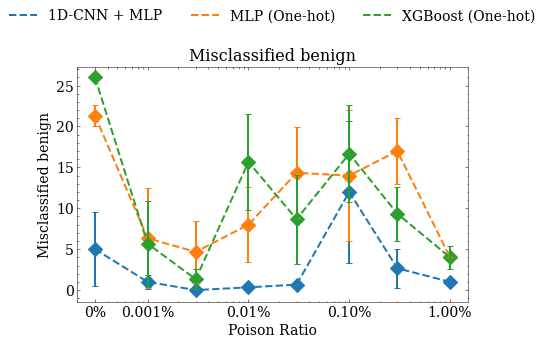

In [4]:
for metric in metrics:
    ax = joint_metric_plot(metric)
    ax.set_title(metric.capitalize().replace("_", " "), fontsize=16)